In [54]:
!pip install colorama lightgbm pandas numpy scikit-learn matplotlib seaborn xgboost catboost optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 43.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 14.0 MB/s eta 0:00:00


In [55]:
from colorama import Fore, Style
from concurrent.futures import ThreadPoolExecutor
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import os
import optuna
import pandas as pd
import re
from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score,accuracy_score
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from tqdm import tqdm
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.base import RegressorMixin, BaseEstimator
from sklearn.utils.validation import check_is_fitted

/opt/homebrew/anaconda3/envs/kubeflow/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [37]:
SEED = 42
n_splits = 5
target = "sii"

In [38]:
# Load preprocessed data
train_re = pd.read_csv("dataset/train_re.csv")
train_rf = pd.read_csv("dataset/train_rf.csv")

In [39]:
# Standardize continuous features
data_dict = pd.read_csv("dataset/data_dictionary.csv")
category_fields = data_dict[data_dict["Type"].str.contains("categorical", case=False, na=False)]["Field"]
continuous_features = [col for col in train_re.columns if col not in category_fields.values and col not in ["PCIAT-PCIAT_Total", "sii"]]

scaler = StandardScaler()
train_re.loc[:, continuous_features] = scaler.fit_transform(train_re[continuous_features])
train_rf.loc[:, continuous_features] = scaler.fit_transform(train_rf[continuous_features])

#print(train_re.info())
#print(train_rf.describe())

/var/folders/l3/jvrwplzx77z55jbbtyh6nxbw0000gn/T/ipykernel_47790/3196149086.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.52798399 -0.36116373 -0.06945867 ...  0.80565653  0.2222464
  0.80565653]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_re.loc[:, continuous_features] = scaler.fit_transform(train_re[continuous_features])


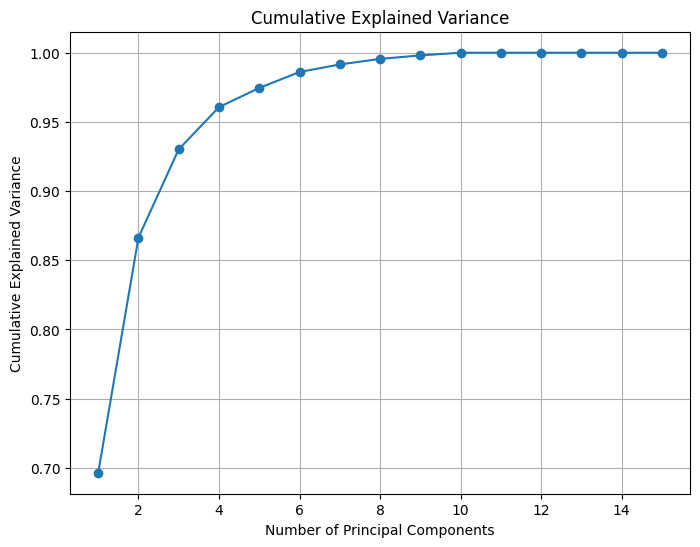

Number of components for 99.0% variance: 7


In [40]:
# Decide the number of components for PCA - physical features
BIA_features = [
    "BIA-BIA_BMI",
    "BIA-BIA_Frame_num",
    "BIA-BIA_FFMI",
    "BIA-BIA_FMI",
    "BIA-BIA_BMC",
    "BIA-BIA_BMR",
    "BIA-BIA_DEE",
    "BIA-BIA_ECW",
    "BIA-BIA_FFM",
    "BIA-BIA_Fat",
    "BIA-BIA_ICW",
    "BIA-BIA_LDM",
    "BIA-BIA_LST",
    "BIA-BIA_SMM",
    "BIA-BIA_TBW",
]

pca = PCA()
pca.fit(train_re[BIA_features])

# Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

# Choose the number of components
desired_variance = 0.99  # 99% of variance
n_components = (pca.explained_variance_ratio_.cumsum() >= desired_variance).argmax() + 1
print(f"Number of components for {desired_variance*100}% variance: {n_components}")

In [41]:
# Apply PCA for physical features
n_components = 7
pca = PCA(n_components=n_components)
train_BIA_re = pca.fit_transform(train_re[BIA_features])

train_BIA_pca_re = pd.DataFrame(train_BIA_re, columns=[f"PC{i+1}" for i in range(n_components)])

# Combine the PCA components and other features
other_features = [col for col in train_re.columns if col not in BIA_features and col not in ["PCIAT-PCIAT_Total", "sii"]]
train_pca_re = pd.concat([train_BIA_pca_re, train_re[other_features].reset_index(drop=True)], axis=1)

# Add the target column "sii" to train_pca
train_pca_re[target] = train_re[target].reset_index(drop=True)

#print(train_pca_re.info())
#print(train_pca_re.describe())

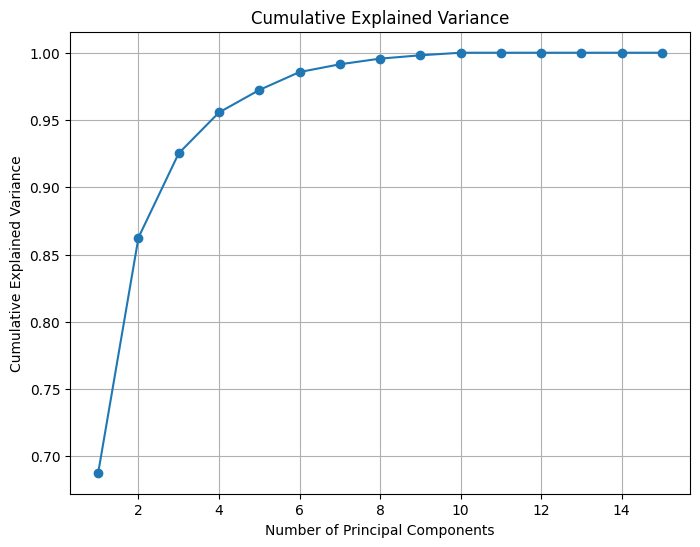

Number of components for 99.0% variance: 7


In [42]:
BIA_features = [
    "BIA-BIA_BMI",
    "BIA-BIA_Frame_num",
    "BIA-BIA_FFMI",
    "BIA-BIA_FMI",
    "BIA-BIA_BMC",
    "BIA-BIA_BMR",
    "BIA-BIA_DEE",
    "BIA-BIA_ECW",
    "BIA-BIA_FFM",
    "BIA-BIA_Fat",
    "BIA-BIA_ICW",
    "BIA-BIA_LDM",
    "BIA-BIA_LST",
    "BIA-BIA_SMM",
    "BIA-BIA_TBW",
]

pca = PCA()
pca.fit(train_rf[BIA_features])

# Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

# Choose the number of components
desired_variance = 0.99  # 99% of variance
n_components = (pca.explained_variance_ratio_.cumsum() >= desired_variance).argmax() + 1
print(f"Number of components for {desired_variance*100}% variance: {n_components}")

In [43]:
# Apply PCA for physical features
n_components = 7
pca = PCA(n_components=n_components)
train_BIA_rf = pca.fit_transform(train_rf[BIA_features])

train_BIA_pca_rf = pd.DataFrame(train_BIA_rf, columns=[f"PC{i+1}" for i in range(n_components)])

# Combine the PCA components and other features
other_features = [col for col in train_rf.columns if col not in BIA_features and col not in ["PCIAT-PCIAT_Total", "sii"]]
train_pca_rf = pd.concat([train_BIA_pca_rf, train_rf[other_features].reset_index(drop=True)], axis=1)

# Add the target column "sii" to train_pca
train_pca_rf[target] = train_rf[target].reset_index(drop=True)

#print(train_pca_rf.info())
#print(train_pca_rf.describe())

In [44]:
# Clean column names in datasets
train_data_re, train_data_rf = [
    df.rename(columns=lambda x: re.sub(r'[^A-Za-z0-9_]', '_', x))  # Use re.sub for regex replacement
    for df in [train_pca_re, train_pca_rf]
]

#print(train_data_re.info())
#print(train_data_re.describe())
#print(train_data_rf.info())
#print(train_data_rf.describe())

In [45]:
# Evaluation
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')
    
def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

In [46]:
# Define a weighted voting regressor
class WeightedVotingRegressor(RegressorMixin, BaseEstimator):
    def __init__(self, estimators, weights=None):
        self.estimators = estimators
        self.weights = weights

    def fit(self, X, y):
        # Fit all base estimators
        for _, estimator in self.estimators:
            estimator.fit(X, y)
        self.fitted_ = True  # Mark as fitted
        return self

    def predict(self, X):
        # Ensure all models are fitted
        check_is_fitted(self, attributes=["fitted_"])
        
        # Aggregate predictions with weights
        predictions = np.array([estimator.predict(X) for _, estimator in self.estimators])
        if self.weights is None:
            return np.mean(predictions, axis=0)
        else:
            return np.average(predictions, axis=0, weights=self.weights)

In [69]:
# Define the training function
def TrainML_with_weights(models, train_data):
    X = train_data.drop([target], axis=1)
    y = train_data[target]

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

    model_results = []
    feature_importances = pd.DataFrame(index=X.columns)

    # Initialize feature importance storage for each model
    for model_name in models.keys():
        feature_importances[model_name] = 0

    # Train each model individually
    for name, model in models.items():
        train_S = []
        test_S = []

        oof_non_rounded = np.zeros(len(y), dtype=float)
        for fold, (train_idx, test_idx) in enumerate(SKF.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

            model.fit(X_train, y_train)
            y_val_pred = model.predict(X_val)

            oof_non_rounded[test_idx] = y_val_pred
            val_kappa = quadratic_weighted_kappa(y_val, y_val_pred.round(0).astype(int))
            test_S.append(val_kappa)

            # Accumulate feature importance if the model supports it
            if hasattr(model, "feature_importances_"):
                feature_importances[name] += model.feature_importances_ / n_splits
            elif hasattr(model, "get_feature_importance"):  # For CatBoost
                feature_importances[name] += model.get_feature_importance() / n_splits

        mean_val_kappa = np.mean(test_S)
        model_results.append((name, model, mean_val_kappa))
        print(f"Model {name} - Mean Validation QWK: {mean_val_kappa:.4f}")

    # Calculate weights based on Mean Validation QWK
    kappas = np.array([result[2] for result in model_results])
    weights = kappas / kappas.sum()  # Normalize QWK to create weights
    print(f"Model Weights: {weights}")

    # Normalize feature importance for plotting
    feature_importances["Normalized"] = feature_importances.sum(axis=1) / feature_importances.sum(axis=1).sum() * 100

    # Optimized thresholds for QWK
    KappaOptimizer = minimize(
        evaluate_predictions,
        x0=[0.5, 1.5, 2.5],
        args=(y, oof_non_rounded),
        method="Nelder-Mead",
    )
    assert KappaOptimizer.success, "Optimization did not converge"

    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOptimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)
    tAccuracy = accuracy_score(y, oof_tuned)

    print(f"---> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT}{tKappa:.4f}{Style.RESET_ALL}")
    print(f"---> || Optimized Accuracy :: {Fore.GREEN}{Style.BRIGHT}{tAccuracy:.4f}{Style.RESET_ALL}")

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    feature_importances["Normalized"].sort_values(ascending=True).plot(
        kind="barh", color="#4f78ec"
    )
    plt.xlabel("Normalized Importance (%)")
    plt.ylabel("Features")
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.show()

    # Display feature importance table
    print("\nFeature Importances (Normalized):")
    print(feature_importances["Normalized"])

    # Return results
    return {
        "feature_importances": feature_importances,
        "optimized_qwk": tKappa,
        "optimized_accuracy": tAccuracy,
    }

In [59]:
# Objective function for LightGBM maximizing QWK
def objective_lightgbm_qwk(trial, train_data):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 4, 16),
        'num_leaves': trial.suggest_int('num_leaves', 20, 500),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 50),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0),
    }
    model = LGBMRegressor(**params, random_state=SEED, verbose=-1, n_estimators=300)
    oof_predictions = np.zeros(len(train_data))

    X, y = train_data.drop(columns=[target]), train_data[target]

    for train_idx, valid_idx in StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED).split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        model.fit(X_train, y_train)

        oof_predictions[valid_idx] = model.predict(X_valid)

    thresholds = [0.5, 1.5, 2.5]
    optimized_thresholds = minimize(evaluate_predictions, x0=thresholds, args=(y, oof_predictions), method="Nelder-Mead").x
    rounded_preds = threshold_Rounder(oof_predictions, optimized_thresholds)
    return quadratic_weighted_kappa(y, rounded_preds)

# Objective functions for XGBoost maximizing QWK
def objective_xgboost_qwk(trial, train_data):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
    }
    model = XGBRegressor(**params, random_state=SEED, tree_method='auto')
    oof_predictions = np.zeros(len(train_data))

    X, y = train_data.drop(columns=[target]), train_data[target]

    for train_idx, valid_idx in StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED).split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        model.fit(X_train, y_train)

        oof_predictions[valid_idx] = model.predict(X_valid)

    thresholds = [0.5, 1.5, 2.5]
    optimized_thresholds = minimize(evaluate_predictions, x0=thresholds, args=(y, oof_predictions), method="Nelder-Mead").x
    rounded_preds = threshold_Rounder(oof_predictions, optimized_thresholds)
    return quadratic_weighted_kappa(y, rounded_preds)

# Objective functions for CatBoost maximizing QWK
def objective_catboost_qwk(trial, train_data):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 4, 12),
        'iterations': trial.suggest_int('iterations', 100, 500),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
    }
    model = CatBoostRegressor(**params, random_seed=SEED, verbose=0, task_type='CPU')
    oof_predictions = np.zeros(len(train_data))

    X, y = train_data.drop(columns=[target]), train_data[target]

    for train_idx, valid_idx in StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED).split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        model.fit(X_train, y_train)

        oof_predictions[valid_idx] = model.predict(X_valid)

    thresholds = [0.5, 1.5, 2.5]
    optimized_thresholds = minimize(evaluate_predictions, x0=thresholds, args=(y, oof_predictions), method="Nelder-Mead").x
    rounded_preds = threshold_Rounder(oof_predictions, optimized_thresholds)
    return quadratic_weighted_kappa(y, rounded_preds)

# Optimize with Optuna
print("Optimizing LightGBM...")
study_lightgbm_qwk = optuna.create_study(direction='maximize')
study_lightgbm_qwk.optimize(lambda trial: objective_lightgbm_qwk(trial, train_data_re), n_trials=15)

print("Optimizing XGBoost...")
study_xgboost_qwk = optuna.create_study(direction='maximize')
study_xgboost_qwk.optimize(lambda trial: objective_xgboost_qwk(trial, train_data_re), n_trials=15)

print("Optimizing CatBoost...")
study_catboost_qwk = optuna.create_study(direction='maximize')
study_catboost_qwk.optimize(lambda trial: objective_catboost_qwk(trial, train_data_re), n_trials=15)

# Retrieve best parameters
best_lightgbm_params_qwk = study_lightgbm_qwk.best_params
best_xgboost_params_qwk = study_xgboost_qwk.best_params
best_catboost_params_qwk = study_catboost_qwk.best_params

print("Best LightGBM Parameters:", best_lightgbm_params_qwk)
print("Best XGBoost Parameters:", best_xgboost_params_qwk)
print("Best CatBoost Parameters:", best_catboost_params_qwk)

[I 2024-12-12 14:25:10,102] A new study created in memory with name: no-name-9fc37ae8-73a4-4fd9-96f6-4181b517d60c


Optimizing LightGBM...


[I 2024-12-12 14:25:14,282] Trial 0 finished with value: 0.4184178791012636 and parameters: {'learning_rate': 0.093653704840353, 'max_depth': 8, 'num_leaves': 186, 'min_data_in_leaf': 12, 'feature_fraction': 0.5854414714562941, 'bagging_fraction': 0.8806492253389211, 'bagging_freq': 5, 'lambda_l1': 1.0851001541974625, 'lambda_l2': 4.947760977546452}. Best is trial 0 with value: 0.4184178791012636.
[I 2024-12-12 14:25:17,353] Trial 1 finished with value: 0.43677075102564134 and parameters: {'learning_rate': 0.08191442701123744, 'max_depth': 7, 'num_leaves': 56, 'min_data_in_leaf': 8, 'feature_fraction': 0.6034140145095926, 'bagging_fraction': 0.665478836711507, 'bagging_freq': 8, 'lambda_l1': 3.686577544810757, 'lambda_l2': 3.4498823420452887}. Best is trial 1 with value: 0.43677075102564134.
[I 2024-12-12 14:25:19,299] Trial 2 finished with value: 0.4056736866294667 and parameters: {'learning_rate': 0.08381115400437075, 'max_depth': 13, 'num_leaves': 448, 'min_data_in_leaf': 37, 'featu

Optimizing XGBoost...


[I 2024-12-12 14:25:49,780] Trial 0 finished with value: 0.4709055974402745 and parameters: {'learning_rate': 0.03545671829159326, 'max_depth': 8, 'n_estimators': 183, 'subsample': 0.853362176609636, 'colsample_bytree': 0.6118196342472644, 'reg_alpha': 9.59730250273222, 'reg_lambda': 0.7120732684510978}. Best is trial 0 with value: 0.4709055974402745.
[I 2024-12-12 14:25:51,021] Trial 1 finished with value: 0.43888419529478173 and parameters: {'learning_rate': 0.09403453769127122, 'max_depth': 5, 'n_estimators': 221, 'subsample': 0.6944628333011865, 'colsample_bytree': 0.8158026175255368, 'reg_alpha': 3.565024729114894, 'reg_lambda': 7.576635389196474}. Best is trial 0 with value: 0.4709055974402745.
[I 2024-12-12 14:25:58,221] Trial 2 finished with value: 0.4244808614144142 and parameters: {'learning_rate': 0.09138055038813772, 'max_depth': 11, 'n_estimators': 481, 'subsample': 0.6137641808819934, 'colsample_bytree': 0.9524705189559346, 'reg_alpha': 0.8060780953604896, 'reg_lambda': 4

Optimizing CatBoost...


[I 2024-12-12 14:27:32,055] Trial 0 finished with value: 0.46179920251992923 and parameters: {'learning_rate': 0.016255921042457162, 'depth': 12, 'iterations': 400, 'l2_leaf_reg': 5.6892182893044065}. Best is trial 0 with value: 0.46179920251992923.
[I 2024-12-12 14:27:33,455] Trial 1 finished with value: 0.45912598142067795 and parameters: {'learning_rate': 0.08274471453476384, 'depth': 5, 'iterations': 308, 'l2_leaf_reg': 5.295929630984559}. Best is trial 0 with value: 0.46179920251992923.
[I 2024-12-12 14:27:39,109] Trial 2 finished with value: 0.44366325198061474 and parameters: {'learning_rate': 0.08908295563657434, 'depth': 8, 'iterations': 401, 'l2_leaf_reg': 4.322497875483185}. Best is trial 0 with value: 0.46179920251992923.
[I 2024-12-12 14:27:47,550] Trial 3 finished with value: 0.46412669959274333 and parameters: {'learning_rate': 0.057819184777918115, 'depth': 11, 'iterations': 112, 'l2_leaf_reg': 9.590780830379114}. Best is trial 3 with value: 0.46412669959274333.
[I 2024

Best LightGBM Parameters: {'learning_rate': 0.010751978192889856, 'max_depth': 16, 'num_leaves': 331, 'min_data_in_leaf': 48, 'feature_fraction': 0.696016080806032, 'bagging_fraction': 0.9879380403465966, 'bagging_freq': 1, 'lambda_l1': 9.640351490233046, 'lambda_l2': 2.3292305037476697}
Best XGBoost Parameters: {'learning_rate': 0.015423196798368538, 'max_depth': 6, 'n_estimators': 317, 'subsample': 0.6728864078716785, 'colsample_bytree': 0.7854934921134717, 'reg_alpha': 8.94849535537006, 'reg_lambda': 0.009052099420350235}
Best CatBoost Parameters: {'learning_rate': 0.01423506041104803, 'depth': 8, 'iterations': 494, 'l2_leaf_reg': 1.3791210958681106}


Regression-based imputation: 
Model lightgbm - Mean Validation QWK: 0.3674
Model xgboost - Mean Validation QWK: 0.3810
0:	learn: 0.7674225	total: 4.41ms	remaining: 2.17s
1:	learn: 0.7644970	total: 7.25ms	remaining: 1.78s
2:	learn: 0.7618240	total: 10.3ms	remaining: 1.69s
3:	learn: 0.7592640	total: 13.3ms	remaining: 1.63s
4:	learn: 0.7568993	total: 16.6ms	remaining: 1.62s
5:	learn: 0.7545861	total: 20.3ms	remaining: 1.65s
6:	learn: 0.7522777	total: 23.1ms	remaining: 1.61s
7:	learn: 0.7500990	total: 26.3ms	remaining: 1.6s
8:	learn: 0.7477020	total: 30ms	remaining: 1.61s
9:	learn: 0.7455216	total: 33ms	remaining: 1.6s
10:	learn: 0.7432187	total: 36.1ms	remaining: 1.58s
11:	learn: 0.7410706	total: 38.7ms	remaining: 1.55s
12:	learn: 0.7390437	total: 41.5ms	remaining: 1.53s
13:	learn: 0.7369664	total: 44.2ms	remaining: 1.51s
14:	learn: 0.7346974	total: 46.7ms	remaining: 1.49s
15:	learn: 0.7326818	total: 49.6ms	remaining: 1.48s
16:	learn: 0.7306467	total: 52.7ms	remaining: 1.48s
17:	learn: 0.

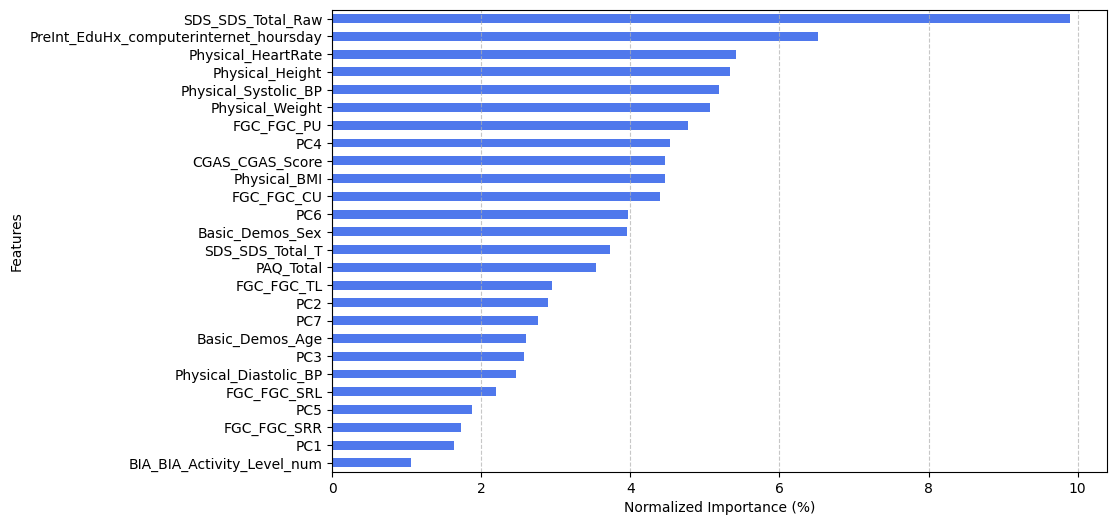


Feature Importances (Normalized):
PC1                                       1.630523
PC2                                       2.898882
PC3                                       2.571172
PC4                                       4.526048
PC5                                       1.876131
PC6                                       3.966192
PC7                                       2.758787
Basic_Demos_Age                           2.596477
Basic_Demos_Sex                           3.953796
CGAS_CGAS_Score                           4.468945
Physical_BMI                              4.461294
Physical_Height                           5.332708
Physical_Weight                           5.069360
Physical_Diastolic_BP                     2.471728
Physical_HeartRate                        5.423280
Physical_Systolic_BP                      5.188483
FGC_FGC_CU                                4.400758
FGC_FGC_PU                                4.778799
FGC_FGC_SRL                               2.199

{'feature_importances':                                         lightgbm   xgboost   catboost  \
 PC1                                         86.8  0.034343   2.420489   
 PC2                                        156.2  0.017100   2.467722   
 PC3                                        138.2  0.014484   2.531451   
 PC4                                        245.2  0.021704   2.534161   
 PC5                                        100.4  0.013851   2.285560   
 PC6                                        213.8  0.022492   3.286879   
 PC7                                        148.4  0.017839   2.598165   
 Basic_Demos_Age                            136.4  0.239112   5.492045   
 Basic_Demos_Sex                            211.6  0.042540   4.788265   
 CGAS_CGAS_Score                            241.2  0.022793   3.407233   
 Physical_BMI                               241.4  0.018150   2.793058   
 Physical_Height                            287.0  0.083073   4.829354   
 Physical_Weigh

In [70]:
# LightGBM parameters
Params = {'learning_rate': 0.010751978192889856, 'max_depth': 16, 'num_leaves': 331, 'min_data_in_leaf': 48, 'feature_fraction': 0.696016080806032, 'bagging_fraction': 0.9879380403465966, 'bagging_freq': 1, 'lambda_l1': 9.640351490233046, 'lambda_l2': 2.3292305037476697}
 
# XGBoost parameters
XGB_Params = {'learning_rate': 0.015423196798368538, 'max_depth': 6, 'n_estimators': 317, 'subsample': 0.6728864078716785, 'colsample_bytree': 0.7854934921134717, 'reg_alpha': 8.94849535537006, 'reg_lambda': 0.009052099420350235}

# CatBoost parameters
CatBoost_Params = {'learning_rate': 0.01423506041104803, 'depth': 8, 'iterations': 494, 'l2_leaf_reg': 1.3791210958681106}

models = {
    "lightgbm": LGBMRegressor(**Params, random_state=SEED, verbose=-1, n_estimators=300),
    "xgboost": XGBRegressor(**XGB_Params),
    "catboost": CatBoostRegressor(**CatBoost_Params)
}

print("Regression-based imputation: ")
TrainML_with_weights(models, train_data_re)

In [65]:
# Objective function for LightGBM maximizing QWK
def objective_lightgbm_qwk(trial, train_data):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 4, 16),
        'num_leaves': trial.suggest_int('num_leaves', 20, 500),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 50),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0),
    }
    model = LGBMRegressor(**params, random_state=SEED, verbose=-1, n_estimators=300)
    oof_predictions = np.zeros(len(train_data))

    X, y = train_data.drop(columns=[target]), train_data[target]

    for train_idx, valid_idx in StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED).split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        model.fit(X_train, y_train)

        oof_predictions[valid_idx] = model.predict(X_valid)

    thresholds = [0.5, 1.5, 2.5]
    optimized_thresholds = minimize(evaluate_predictions, x0=thresholds, args=(y, oof_predictions), method="Nelder-Mead").x
    rounded_preds = threshold_Rounder(oof_predictions, optimized_thresholds)
    return quadratic_weighted_kappa(y, rounded_preds)

# Objective functions for XGBoost maximizing QWK
def objective_xgboost_qwk(trial, train_data):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
    }
    model = XGBRegressor(**params, random_state=SEED, tree_method='auto')
    oof_predictions = np.zeros(len(train_data))

    X, y = train_data.drop(columns=[target]), train_data[target]

    for train_idx, valid_idx in StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED).split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        model.fit(X_train, y_train)

        oof_predictions[valid_idx] = model.predict(X_valid)

    thresholds = [0.5, 1.5, 2.5]
    optimized_thresholds = minimize(evaluate_predictions, x0=thresholds, args=(y, oof_predictions), method="Nelder-Mead").x
    rounded_preds = threshold_Rounder(oof_predictions, optimized_thresholds)
    return quadratic_weighted_kappa(y, rounded_preds)

# Objective functions for CatBoost maximizing QWK
def objective_catboost_qwk(trial, train_data):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 4, 12),
        'iterations': trial.suggest_int('iterations', 100, 500),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
    }
    model = CatBoostRegressor(**params, random_seed=SEED, verbose=0, task_type='CPU')
    oof_predictions = np.zeros(len(train_data))

    X, y = train_data.drop(columns=[target]), train_data[target]

    for train_idx, valid_idx in StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED).split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        model.fit(X_train, y_train)

        oof_predictions[valid_idx] = model.predict(X_valid)

    thresholds = [0.5, 1.5, 2.5]
    optimized_thresholds = minimize(evaluate_predictions, x0=thresholds, args=(y, oof_predictions), method="Nelder-Mead").x
    rounded_preds = threshold_Rounder(oof_predictions, optimized_thresholds)
    return quadratic_weighted_kappa(y, rounded_preds)

# Optimize with Optuna
print("Optimizing LightGBM...")
study_lightgbm_qwk = optuna.create_study(direction='maximize')
study_lightgbm_qwk.optimize(lambda trial: objective_lightgbm_qwk(trial, train_data_rf), n_trials=15)

print("Optimizing XGBoost...")
study_xgboost_qwk = optuna.create_study(direction='maximize')
study_xgboost_qwk.optimize(lambda trial: objective_xgboost_qwk(trial, train_data_rf), n_trials=15)

print("Optimizing CatBoost...")
study_catboost_qwk = optuna.create_study(direction='maximize')
study_catboost_qwk.optimize(lambda trial: objective_catboost_qwk(trial, train_data_rf), n_trials=15)

# Retrieve best parameters
best_lightgbm_params_qwk = study_lightgbm_qwk.best_params
best_xgboost_params_qwk = study_xgboost_qwk.best_params
best_catboost_params_qwk = study_catboost_qwk.best_params

print("Best LightGBM Parameters:", best_lightgbm_params_qwk)
print("Best XGBoost Parameters:", best_xgboost_params_qwk)
print("Best CatBoost Parameters:", best_catboost_params_qwk)

[I 2024-12-12 14:35:26,101] A new study created in memory with name: no-name-00d57a72-2e94-4211-8fbd-c461301248b6


Optimizing LightGBM...


[I 2024-12-12 14:35:31,163] Trial 0 finished with value: 0.418787597430206 and parameters: {'learning_rate': 0.05049873192806158, 'max_depth': 12, 'num_leaves': 306, 'min_data_in_leaf': 18, 'feature_fraction': 0.5517454589529877, 'bagging_fraction': 0.7247927454554033, 'bagging_freq': 2, 'lambda_l1': 2.019958915219102, 'lambda_l2': 0.15818100767436505}. Best is trial 0 with value: 0.418787597430206.
[I 2024-12-12 14:35:33,301] Trial 1 finished with value: 0.45705726489327314 and parameters: {'learning_rate': 0.01690797894117063, 'max_depth': 9, 'num_leaves': 204, 'min_data_in_leaf': 40, 'feature_fraction': 0.514258048052137, 'bagging_fraction': 0.6771700828919267, 'bagging_freq': 10, 'lambda_l1': 2.948900388478206, 'lambda_l2': 6.444821570113816}. Best is trial 1 with value: 0.45705726489327314.
[I 2024-12-12 14:35:37,083] Trial 2 finished with value: 0.4395934967162697 and parameters: {'learning_rate': 0.043558595309035324, 'max_depth': 10, 'num_leaves': 195, 'min_data_in_leaf': 20, '

Optimizing XGBoost...


[I 2024-12-12 14:36:15,746] Trial 0 finished with value: 0.4601388681800047 and parameters: {'learning_rate': 0.03870235633565011, 'max_depth': 8, 'n_estimators': 158, 'subsample': 0.9319240692327128, 'colsample_bytree': 0.879242893813722, 'reg_alpha': 8.595755063785479, 'reg_lambda': 3.0684590284213775}. Best is trial 0 with value: 0.4601388681800047.
[I 2024-12-12 14:36:21,552] Trial 1 finished with value: 0.4448276548248328 and parameters: {'learning_rate': 0.04348714583080903, 'max_depth': 7, 'n_estimators': 493, 'subsample': 0.6788762983637705, 'colsample_bytree': 0.560411832184498, 'reg_alpha': 2.3557376360870474, 'reg_lambda': 4.701684246164714}. Best is trial 0 with value: 0.4601388681800047.
[I 2024-12-12 14:36:22,975] Trial 2 finished with value: 0.444714830330762 and parameters: {'learning_rate': 0.08685625931764543, 'max_depth': 5, 'n_estimators': 274, 'subsample': 0.5666122714895327, 'colsample_bytree': 0.8012960067511272, 'reg_alpha': 7.87688128156601, 'reg_lambda': 2.488

Optimizing CatBoost...


[I 2024-12-12 14:37:10,153] Trial 0 finished with value: 0.4755487278063365 and parameters: {'learning_rate': 0.024114539814440165, 'depth': 10, 'iterations': 437, 'l2_leaf_reg': 1.5191018930391258}. Best is trial 0 with value: 0.4755487278063365.
[I 2024-12-12 14:37:14,285] Trial 1 finished with value: 0.47118505359945917 and parameters: {'learning_rate': 0.053686950880259515, 'depth': 9, 'iterations': 168, 'l2_leaf_reg': 9.221869893716454}. Best is trial 0 with value: 0.4755487278063365.
[I 2024-12-12 14:37:16,136] Trial 2 finished with value: 0.4486340176410478 and parameters: {'learning_rate': 0.09608139305864698, 'depth': 6, 'iterations': 321, 'l2_leaf_reg': 1.615244628061198}. Best is trial 0 with value: 0.4755487278063365.
[I 2024-12-12 14:37:24,978] Trial 3 finished with value: 0.4469271576704844 and parameters: {'learning_rate': 0.09195650003748938, 'depth': 9, 'iterations': 375, 'l2_leaf_reg': 2.3305772616024143}. Best is trial 0 with value: 0.4755487278063365.
[I 2024-12-12 

Best LightGBM Parameters: {'learning_rate': 0.010439014484556409, 'max_depth': 16, 'num_leaves': 196, 'min_data_in_leaf': 33, 'feature_fraction': 0.9751997081493722, 'bagging_fraction': 0.5854549176475774, 'bagging_freq': 5, 'lambda_l1': 6.863242788452179, 'lambda_l2': 7.6689584631063665}
Best XGBoost Parameters: {'learning_rate': 0.04521146779889634, 'max_depth': 3, 'n_estimators': 186, 'subsample': 0.63720952355899, 'colsample_bytree': 0.8302357296254976, 'reg_alpha': 3.067331701047318, 'reg_lambda': 9.423259606514913}
Best CatBoost Parameters: {'learning_rate': 0.06036786350596943, 'depth': 7, 'iterations': 252, 'l2_leaf_reg': 4.4721588429208134}


KNN & Random Forest imputation: 
Model lightgbm - Mean Validation QWK: 0.3700
Model xgboost - Mean Validation QWK: 0.3794
0:	learn: 0.7603811	total: 2.07ms	remaining: 519ms
1:	learn: 0.7509930	total: 3.88ms	remaining: 485ms
2:	learn: 0.7433869	total: 5.83ms	remaining: 484ms
3:	learn: 0.7355268	total: 7.77ms	remaining: 482ms
4:	learn: 0.7284518	total: 9.77ms	remaining: 483ms
5:	learn: 0.7212749	total: 12.5ms	remaining: 511ms
6:	learn: 0.7156981	total: 14.4ms	remaining: 503ms
7:	learn: 0.7096083	total: 16.3ms	remaining: 496ms
8:	learn: 0.7044341	total: 18.2ms	remaining: 492ms
9:	learn: 0.6993584	total: 20.1ms	remaining: 485ms
10:	learn: 0.6944528	total: 22.2ms	remaining: 487ms
11:	learn: 0.6897132	total: 24ms	remaining: 479ms
12:	learn: 0.6852853	total: 26.1ms	remaining: 481ms
13:	learn: 0.6809596	total: 28.4ms	remaining: 482ms
14:	learn: 0.6775535	total: 30.2ms	remaining: 477ms
15:	learn: 0.6737239	total: 32.1ms	remaining: 473ms
16:	learn: 0.6697987	total: 33.9ms	remaining: 469ms
17:	le

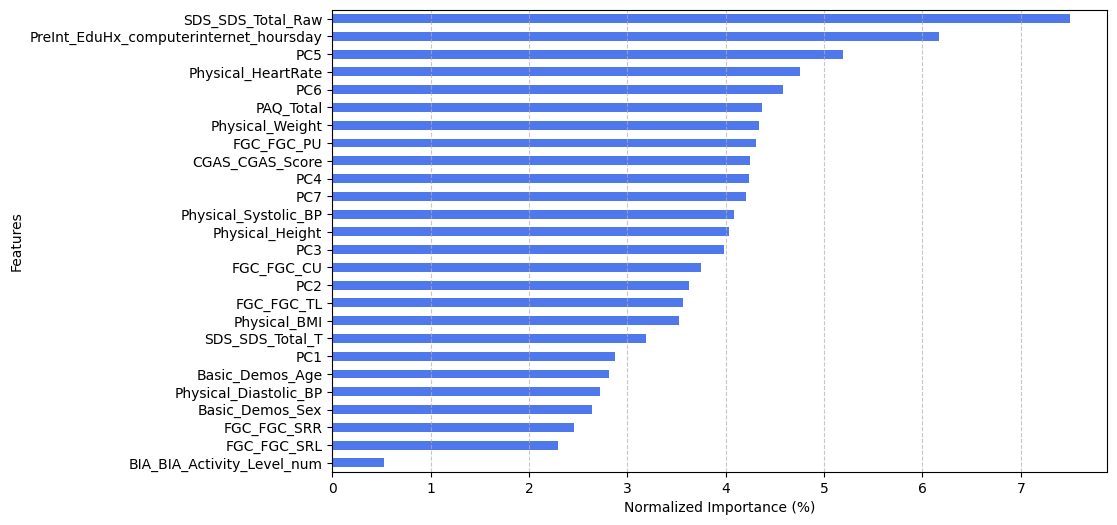


Feature Importances (Normalized):
PC1                                       2.872183
PC2                                       3.625309
PC3                                       3.979904
PC4                                       4.240384
PC5                                       5.193687
PC6                                       4.587169
PC7                                       4.204095
Basic_Demos_Age                           2.809824
Basic_Demos_Sex                           2.641187
CGAS_CGAS_Score                           4.247240
Physical_BMI                              3.527914
Physical_Height                           4.030163
Physical_Weight                           4.339075
Physical_Diastolic_BP                     2.726956
Physical_HeartRate                        4.757045
Physical_Systolic_BP                      4.089387
FGC_FGC_CU                                3.753930
FGC_FGC_PU                                4.307044
FGC_FGC_SRL                               2.291

{'feature_importances':                                         lightgbm   xgboost  catboost  \
 PC1                                        151.2  0.045832  3.312102   
 PC2                                        192.2  0.020733  2.864377   
 PC3                                        211.2  0.019622  2.946962   
 PC4                                        225.6  0.022923  2.560600   
 PC5                                        276.0  0.018624  3.464062   
 PC6                                        243.4  0.020443  3.424289   
 PC7                                        222.2  0.021689  4.009063   
 Basic_Demos_Age                            145.8  0.195410  5.206856   
 Basic_Demos_Sex                            138.4  0.035719  3.691854   
 CGAS_CGAS_Score                            225.0  0.021139  3.531325   
 Physical_BMI                               187.4  0.020812  2.423303   
 Physical_Height                            212.2  0.112775  4.558356   
 Physical_Weight            

In [71]:
# LightGBM parameters
Params = {'learning_rate': 0.010439014484556409, 'max_depth': 16, 'num_leaves': 196, 'min_data_in_leaf': 33, 'feature_fraction': 0.9751997081493722, 'bagging_fraction': 0.5854549176475774, 'bagging_freq': 5, 'lambda_l1': 6.863242788452179, 'lambda_l2': 7.6689584631063665}
 
# XGBoost parameters
XGB_Params = {'learning_rate': 0.04521146779889634, 'max_depth': 3, 'n_estimators': 186, 'subsample': 0.63720952355899, 'colsample_bytree': 0.8302357296254976, 'reg_alpha': 3.067331701047318, 'reg_lambda': 9.423259606514913}

# CatBoost parameters
CatBoost_Params = {'learning_rate': 0.06036786350596943, 'depth': 7, 'iterations': 252, 'l2_leaf_reg': 4.4721588429208134}

models = {
    "lightgbm": LGBMRegressor(**Params, random_state=SEED, verbose=-1, n_estimators=300),
    "xgboost": XGBRegressor(**XGB_Params),
    "catboost": CatBoostRegressor(**CatBoost_Params)
}

print("KNN & Random Forest imputation: ")
TrainML_with_weights(models, train_data_rf)